In [ ]:
from __future__ import print_function, division
import os
import torch
import numpy as np
import pandas as pd # for easier csv parsing
from skimage import io, transform # for image io and transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# to ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion() # interactive mode

%matplotlib inline

In [11]:
torch.cuda.is_available()

True

# Custom Classes for Image Dataset Transformations

## Load the Data

In [12]:
# each face is annotated with 68 different landmark points.
# the 'faces' dataset comes with a csv file with annotations which looks like this:

In [13]:
os.getcwd()

'/home/jovyan'

In [49]:
landmarks_frame = pd.read_csv('faces/face_landmarks.csv')

n = 65
img_name = landmarks_frame.iloc[n, 0]
landmarks = landmarks_frame.iloc[n, 1:]
landmarks = np.asarray(landmarks) # convert from dataframe to a numpy array
landmarks = landmarks.astype('float').reshape(-1, 2) # convert items to floats and reshape in a way that each obs will have (x,y) coordinates for each landmark

# print information relative to 65th image
print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape)) #each image has 68 landmarks. Each landmark has x and y coor
print('First 4 Landmarks: {}'.format(landmarks[:4])) 

Image name: person-7.jpg
Landmarks shape: (68, 2)
First 4 Landmarks: [[32. 65.]
 [33. 76.]
 [34. 86.]
 [34. 97.]]


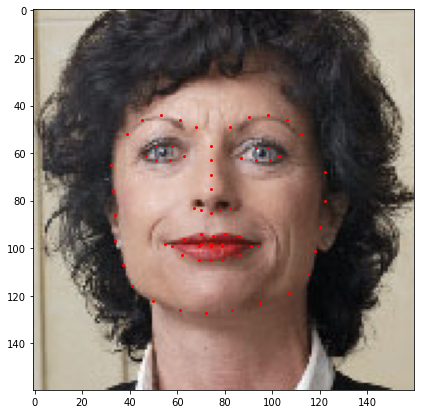

In [56]:
# write a simple helper function to show an image and its landmarks and use it to show a sample.

def show_landmarks(image, landmarks):
    """Show an image with its landmarks"""
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=16, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated

plt.figure(figsize=(7,7))
show_landmarks(io.imread(os.path.join('faces/', img_name)),
               landmarks)
plt.show()

## Dataset class

`torch.utils.data.Dataset` is an abstract class representing a dataset. 

Your custom dataset should **inherit the class Dataset** and override the following methods:

- `__len__` so that `len(dataset)` returns the **size of the dataset**.
- `__getitem__` to **support the indexing** such that `dataset[i]` can be used to get the *ith* sample

Let’s create a dataset class for our face landmarks dataset. We will read the csv in __init__ but leave the reading of images to __getitem__. 

This is memory efficient because all the images are not stored in the memory at once but read as required.

Sample of our dataset will be a dict `{'image': image, 'landmarks': landmarks}`. Our dataset will take an optional argument `transform` so that any required processing can be applied on the sample.

In [57]:
class FaceLandmarksDataset(Dataset): # it inherits from the Dataset class
    """Face Landmarks dataset class."""

    # Class constructor
    def __init__(self, csv_file, root_dir, transform=None): # takes a csv file, the dir with all the images and
                                                            # the optional arg transform
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file) # reads the csv file given as the first arg
        self.root_dir = root_dir # define the root dir given as the second arg
        self.transform = transform # define the transformer if given as a third arg

    def __len__(self):
        return len(self.landmarks_frame) # allows to take the length by doing len(the_new_class)

    def __getitem__(self, idx): # allows to take samples from the dataset by doing the_new_class[0] for example
        if torch.is_tensor(idx):
            idx = idx.tolist() # transform the tensor to list to take the indexes

        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:]
        landmarks = np.array([landmarks])
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample) # if the optional transform is called, apply it one the sample

        return sample

In [73]:
# Let’s instantiate this class and iterate through the data samples.
face_dataset = FaceLandmarksDataset(csv_file='faces/face_landmarks.csv',
                                    root_dir='faces/') # we give it the csv file and the images directory

fig = plt.figure(figsize=(7,7)) # create an object fig

<Figure size 504x504 with 0 Axes>

0 (324, 215, 3) (68, 2)


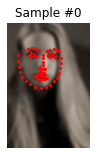

1 (500, 333, 3) (68, 2)


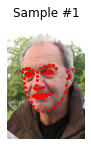

2 (250, 258, 3) (68, 2)


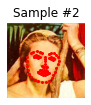

3 (434, 290, 3) (68, 2)


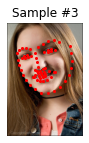

In [79]:
# Iterate through the dataset
# Print the sizes of the first 4 samples and show their landmarks

for i in range(len(face_dataset)):
    sample = face_dataset[i]

    print(i, sample['image'].shape, sample['landmarks'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(**sample)

    if i == 3:
        plt.show()
        break

## Define Transforms

One issue we can see from the above is that the samples are not of the same size. 

Most neural networks expect the images of a fixed size. 

Therefore, we will need to write some **prepocessing code**.

For example, we create three transforms:

- Rescale: to scale the image
- RandomCrop: to crop from image randomly. **This is data augmentation**.
- ToTensor: to convert the numpy images to torch images (here we need to swap axes).

We will write them as **callable classes instead of simple functions** so that **parameters of the transform need not be passed everytime it’s called**. 

For this, we just need to implement __call__ method and if required, __init__ method.

In [80]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'landmarks': landmarks}

In [81]:
class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        landmarks = landmarks - [left, top]

        return {'image': image, 'landmarks': landmarks}

In [82]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

## Compose Transforms

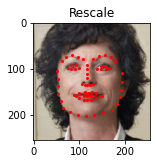

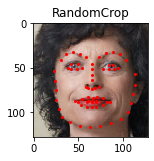

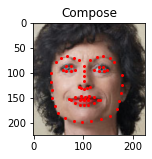

In [88]:
scale = Rescale(256)
crop = RandomCrop(128)
# Apply more than one transform with transforms.Compose
composed = transforms.Compose([Rescale(256),
                               RandomCrop(224)])

# Apply each of the above transforms on the 65th sample.
fig = plt.figure()
sample = face_dataset[65]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(**transformed_sample)

plt.show()

## Iterating through the dataset

In [89]:
# apply all the transforms on the faces dataset, and print the 4 first samples

transformed_dataset = FaceLandmarksDataset(csv_file='faces/face_landmarks.csv',
                                           root_dir='faces/',
                                           transform=transforms.Compose([
                                               Rescale(256),
                                               RandomCrop(224),
                                               ToTensor()
                                           ]))

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]

    print(i, sample['image'].size(), sample['landmarks'].size())

    if i == 3:
        break

0 torch.Size([3, 224, 224]) torch.Size([68, 2])
1 torch.Size([3, 224, 224]) torch.Size([68, 2])
2 torch.Size([3, 224, 224]) torch.Size([68, 2])
3 torch.Size([3, 224, 224]) torch.Size([68, 2])


Since one of the transforms is random, **data is augmentated on sampling**.

However, we are losing a lot of features by using a simple for loop to iterate over the data. 

In particular, we are missing out on:

- Batching the data
- Shuffling the data
- Load the data in parallel using multiprocessing workers.

`torch.utils.data.DataLoaderù` is an iterator which provides all these features. 

Parameters used below should be clear. One parameter of interest is `collate_fn`. You can specify how exactly the samples need to be batched using `collate_fn`. However, default collate should work fine for most use cases.

0 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
1 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
2 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
3 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])


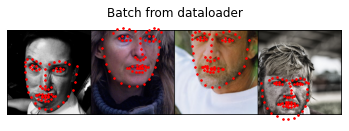

In [94]:
dataloader = DataLoader(transformed_dataset, batch_size=4, # we take 4 observations from the original dataset by shuffling
                        shuffle=True, num_workers=0)


# Helper function to show a batch
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size + (i + 1) * grid_border_size,
                    landmarks_batch[i, :, 1].numpy() + grid_border_size,
                    s=10, marker='.', c='r')

        plt.title('Batch from dataloader')

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['landmarks'].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break